In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-04-22 21:59:11.478545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, n_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.label_embed = nn.Embedding(n_classes, img_size**2)
        
        self.disc = nn.Sequential(
            #input: N x Channels_img x 64 x 64
            nn.Conv2d(channels_img+1,features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self.block(features_d, features_d*2,4,2,1),
            self.block(features_d*2, features_d*4,4,2,1),
            self.block(features_d*4, features_d*8,4,2,1),
            nn.Conv2d(features_d*8,1, kernel_size=4,stride=2,padding=0), #single value output determining if the photo is real
            nn.Sigmoid()
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x, labels):
        e = self.label_embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, e], dim=1)
        return self.disc(x)
            

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, n_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        
        self.label_embed = nn.Embedding(n_classes, embed_size)
        
        self.gen = nn.Sequential(
            self.block(z_dim+embed_size, features_g*16, 4, 1, 0), #N x f_g x 16 x 4 x 4
            self.block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self.block(features_g*8, features_g*4, 4, 2, 1), #16x16
            self.block(features_g*4, features_g*2, 4, 2, 1), #32x32
            # self.block(features_g*2, features_g, 4, 2, 1),
            # self.block(features_g*2, channels_img, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4,stride=2, padding=1,
            ),
            nn.Tanh(), #[-1,1]
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x, labels):
        e = self.label_embed(labels).unsqueeze(2).unsqueeze(3) # creates vector: N x noise x 1 x 1
        x = torch.cat([x,e],dim=1)
        return self.gen(x)

In [4]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
                
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8,10,64)
    init_weights(disc)
    assert disc(x).shape == (N, 1,1,1)
    gen = Generator(z_dim, in_channels, 8,10,64,100)
    z = torch.randn((N, z_dim, 1,1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

# Training the model

In [7]:
#hyperparameters
lr = .0002
batch_size = 128
img_size = 64
channels_img = 3
z_dim = 128
n_epochs = 10
n_classes = 10
gen_embed = 100

# these two need to be the same to match the paper
features_disc = 64
features_gen = 64

In [8]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),
    ]
)


dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms)
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

gen = Generator(z_dim, channels_img, features_gen, n_classes, img_size, gen_embed).to(device)
disc = Discriminator(channels_img, features_disc, n_classes, img_size).to(device)

init_weights(gen)
init_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5,0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32,z_dim, 1,1).to(device)

gen.train()
disc.train()

for epoch in range(n_epochs):
    for step, (real, labels) in enumerate(dataloader):
        
        #because the last item is always a different size
        if step == (len(dataloader)-1):
            break
            
        #init variables
        real = real.to(device)
        labels = labels.to(device)
        noise = torch.randn((batch_size, z_dim, 1,1)).to(device)
        fake = gen(noise, labels)
        
        # train discriminator
        disc_real = disc(real, labels).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake, labels).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        # train generator
        output = disc(fake, labels).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

            
    print(f"epoch {epoch+1}: completed")

RuntimeError: output with shape [1, 64, 64] doesn't match the broadcast shape [3, 64, 64]

# WGAN LOOP:

In [9]:
# hyperparameters
n_epochs = 25
batch_size = 64
lr = 0.00005
z_dim = 128
img_size = 64
channels_img = 3
clip_value = 0.01
sample_interval = 400
critic_epochs = 25
n_classes = 10

features_g = 64
features_c = 64

In [ ]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),
    ]
)


dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms)
# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

gen = Generator(z_dim, channels_img, features_g, n_classes, img_size, gen_embed).to(device)
critic = Discriminator(channels_img, features_c, n_classes, img_size).to(device)

optim_g = torch.optim.RMSprop(gen.parameters(), lr=lr)
optim_c = torch.optim.RMSprop(critic.parameters(), lr=lr)

init_weights(gen)
init_weights(critic)

gen.train()
critic.train()

for epoch in range(n_epochs):
    for step, (real, labels) in enumerate(dataloader):
        if step+1 == len(dataloader):
            break
        
        real = real.to(device)
        labels = labels.to(device)
        
        for _ in range(critic_epochs):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real,labels).reshape(-1) # to flatten the vector
            critic_fake = critic(fake,labels).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) # the formula from the paper
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            optim_c.step()
            
            for p in critic.parameters(): # clip the weights between the threshold
                p.data.clamp_(-clip_value, clip_value)
        
            
        output = critic(fake,labels).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        optim_g.step()
        
    print(f"epoch {epoch+1}: completed")

epoch 1: completed
epoch 2: completed
epoch 3: completed
epoch 4: completed
epoch 5: completed


In [ ]:
torch.save(gen, "./cWGAN_GEN.pth")
torch.save(disc, "cWGAN_DISC.pth")

In [5]:
# gen = Generator()
gen = torch.load("./cWGAN_GEN.pth")
disc = torch.load("bestMNISTcDISC.pth")

torch.Size([1, 3, 64, 64])


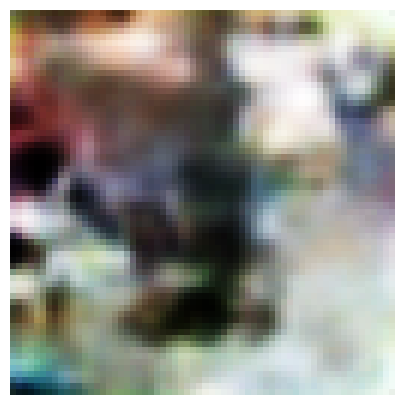

torch.Size([1, 3, 64, 64])


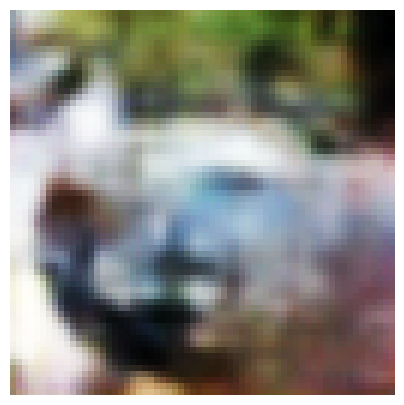

torch.Size([1, 3, 64, 64])


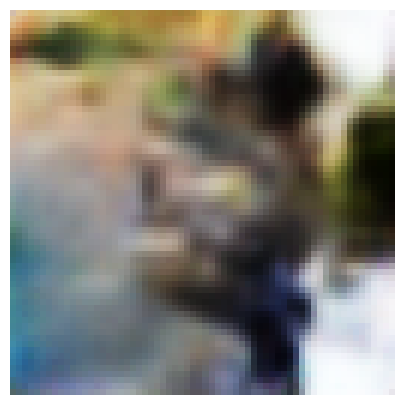

torch.Size([1, 3, 64, 64])


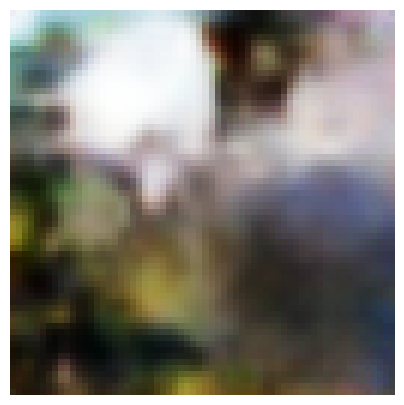

torch.Size([1, 3, 64, 64])


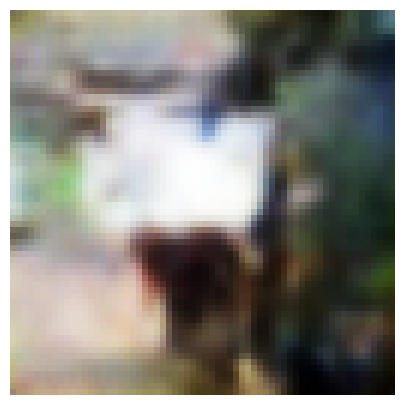

torch.Size([1, 3, 64, 64])


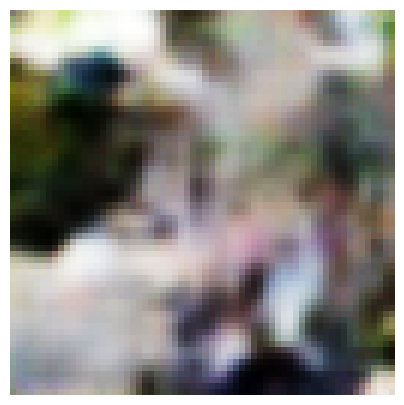

torch.Size([1, 3, 64, 64])


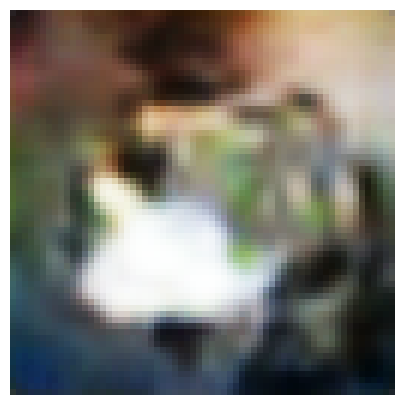

torch.Size([1, 3, 64, 64])


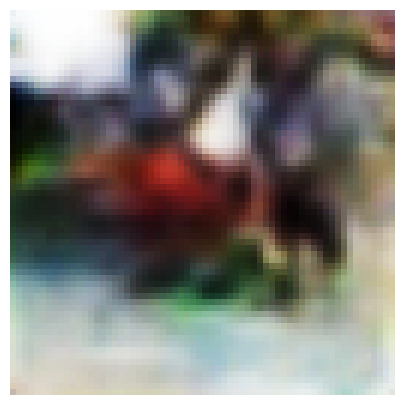

torch.Size([1, 3, 64, 64])


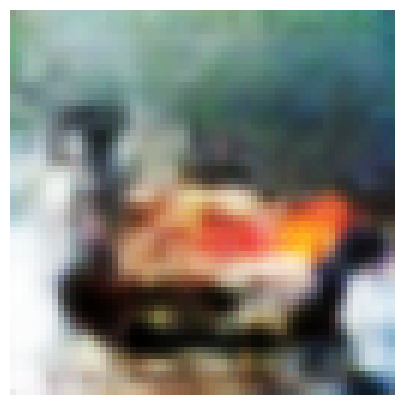

torch.Size([1, 3, 64, 64])


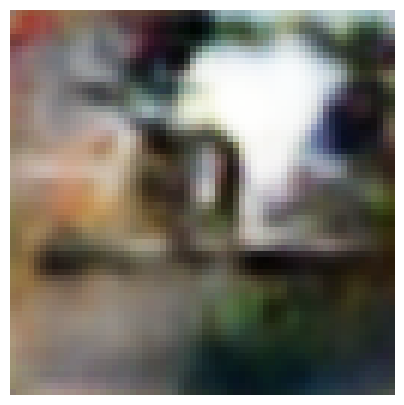

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

for i in range(10):
    condition = torch.tensor([i] * 1, device=device)

    # Generate random noise vectors
    noise = torch.randn(1, 128, 1, 1, device=device)

    # Generate fake images
    fake_images = gen(noise,condition)

    # Rescale pixel values to be between 0 and 1
    fake_images = (fake_images + 1) / 2.0
    print(fake_images.shape)

    # Create a grid of the generated images and display them
    fig = plt.figure(figsize=(5, 5))
    plt.axis("off")
    
    image = np.transpose(vutils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True), (1, 2, 0),)
    plt.imshow(image)
    plt.savefig(f'./gan_img_{i}.jpg')
    plt.show()